# 1: Data Collection & Splitting
## Function Catalog
1. From splitfolders
    - `splitfolders.ratio()` splits data in a folder into train, val and test set according to ratio specified

In [4]:
# data source: https://github.com/UCSD-AI4H/COVID-CT
# directory setting: data folder containing COVID and nonCOVID folders containing images
!pip install split-folders
import splitfolders
splitfolders.ratio(input = "/content/drive/MyDrive/Personal Projects/Covid CT Scans/data",
                    output = "/content/drive/MyDrive/Personal Projects/Covid CT Scans/output", 
                    seed = 2021,
                    ratio = (0.7, 0.15, 0.15)) # train, val, test
# creates folder output with train, val, test folder, each containing COVID and nonCOVID folders with their respective images

Copying files: 746 files [04:00,  3.10 files/s]


# 2: Model Training & Evaluation
## Function Catalog
1. From tensorflow:
    Model Architecture
    - `Densenet169()` is a pre-trained model that can be used for transfer learning
    - `GlobalAveragePooling2D()`, `Dropout()` and `Dense()` are layers
    - `Model()` grouplayers into an object with training and inference features
    Data Augmentation
    - `ImageDataGenerator()` generates batches of tensor images with real time augmentation (1 aug for 1 pic)
        - `.flow_from_directory()`, `ImageDataGenerator.flow_from_directory.classes()`
    Callbacks
    - `EarlyStopping()` stops training model when monitored metric has stopped improving
    - `ModelCheckpoint()` callback to save keras model or its weight at some freqeuncy specified
    - `history.epoch()` returns number of epochs model underwent
    - `history.history()` returns dictionary with keys eg loss
    Training & Evaluation
    - `model.compile()`, `model.fit()`, `model.predict()`. `Adam()`, `confusion_matrix()`, `classification_report()`, `plt.plot`
    Others
    - `np.argmax` returns the indices of the maximum values along an axis

## Build Model Architecture

In [5]:
# import dependencies
import keras
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [6]:
# transfer learning
base_model = densenet.DenseNet169(weights = "imagenet", include_top = False)
# model pre-trained on the imagenet dataset
# build output layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
preds = Dense(2, activation = "sigmoid")(x)
# create full model
model = Model(inputs = base_model.input, outputs = preds)

51879936/51877672 [==============================] - 1s 0us/step


## Data Augmentation

In [7]:
# batch size
BATCH_SIZE = 16
# ImageGenerator object
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                    shear_range = 0.2, 
                                    zoom_range = 0.2, 
                                    brightness_range = [0.2, 1.0], 
                                    horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
# create generators
train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Personal Projects/Covid CT Scans/output/train", 
                                                    target_size = (480, 480), 
                                                    color_mode = "rgb",
                                                    batch_size = BATCH_SIZE, 
                                                    class_mode = "categorical", 
                                                    shuffle = True)
val_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Personal Projects/Covid CT Scans/output/val", 
                                                    target_size = (480, 480), 
                                                    color_mode = "rgb",
                                                    batch_size = BATCH_SIZE, 
                                                    class_mode = "categorical", 
                                                    shuffle = True)
test_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Personal Projects/Covid CT Scans/output/test", 
                                                    target_size = (480, 480), 
                                                    color_mode = "rgb",
                                                    batch_size = BATCH_SIZE, 
                                                    class_mode = "categorical", 
                                                    shuffle = False)

Found 521 images belonging to 2 classes.
Found 111 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


## Model Training

In [8]:
# callbacks
es = EarlyStopping(monitor = "val_loss", patience = 3)
mc = ModelCheckpoint("/content/drive/MyDrive/Personal Projects/Covid CT Scans/best_model.h5", 
                    save_best_only = True)

In [9]:
# compile model for training
model.compile(optimizer = Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics = ["accuracy"])

In [10]:
# model training
history = model.fit(train_generator, 
                        steps_per_epoch = train_generator.samples // BATCH_SIZE,
                        validation_data = val_generator, 
                        validation_steps = val_generator.samples // BATCH_SIZE,
                        epochs = 50,
                        callbacks = [es, mc])

Epoch 1/50
32/32 [==============================] - 109s 2s/step - loss: 0.6345 - accuracy: 0.6792 - val_loss: 0.6449 - val_accuracy: 0.6875
Epoch 2/50
32/32 [==============================] - 46s 1s/step - loss: 0.4149 - accuracy: 0.8297 - val_loss: 0.4693 - val_accuracy: 0.8021
Epoch 3/50
32/32 [==============================] - 46s 1s/step - loss: 0.3371 - accuracy: 0.8673 - val_loss: 0.4983 - val_accuracy: 0.7292
Epoch 4/50
32/32 [==============================] - 47s 1s/step - loss: 0.2719 - accuracy: 0.8970 - val_loss: 0.3877 - val_accuracy: 0.8542
Epoch 5/50
32/32 [==============================] - 48s 1s/step - loss: 0.2348 - accuracy: 0.9043 - val_loss: 0.3693 - val_accuracy: 0.8125
Epoch 6/50
32/32 [==============================] - 47s 1s/step - loss: 0.1649 - accuracy: 0.9426 - val_loss: 0.3484 - val_accuracy: 0.8438
Epoch 7/50
32/32 [==============================] - 46s 1s/step - loss: 0.1370 - accuracy: 0.9584 - val_loss: 0.3014 - val_accuracy: 0.9062
Epoch 8/50
32/32 [=

## Model Evaluation

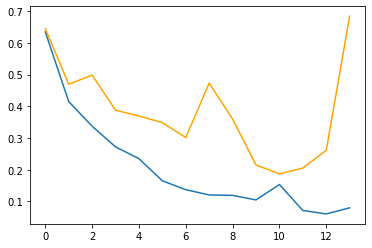

In [12]:
# evaluate loss
plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["val_loss"], color = "orange")

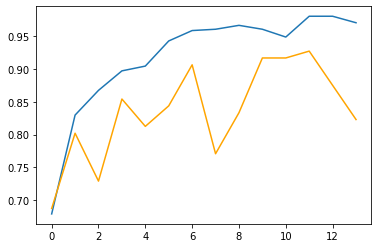

In [13]:
# evaluate accuracy
plt.plot(history.epoch, history.history["accuracy"])
plt.plot(history.epoch, history.history["val_accuracy"], color = "orange")

In [15]:
# test model
test_generator.classes
# make prediction using test data'
predictions = model.predict(test_generator)
predictions
# use np to get predicted classes
single_pred = np.argmax(predictions, axis = 1)
print(confusion_matrix(test_generator.classes, single_pred))
print(classification_report(test_generator.classes, single_pred))

[[31 22]
 [ 0 61]]
              precision    recall  f1-score   support

           0       1.00      0.58      0.74        53
           1       0.73      1.00      0.85        61

    accuracy                           0.81       114
   macro avg       0.87      0.79      0.79       114
weighted avg       0.86      0.81      0.80       114



## Best Model

In [18]:
# use best model
from keras.models import load_model
saved_model = load_model("/content/drive/MyDrive/Personal Projects/Covid CT Scans/best_model.h5")
saved_model

In [ ]:
saved_model_predictions = saved_model.predict(test_generator)
# returns probabilities

In [ ]:
save_single_pred = np.argmax(saved_model_predictions, axis = 1)
# choose class with highest probability
save_single_pred

In [ ]:
print(save_single_pred)
print(confusion_matrix(test_generator.classes, save_single_pred))
print(classification_report(test_generator.classes, save_single_pred))

# FIN
The project is completed with guidance from *[Advanced] Project COVID-CT Scans* free course on UpLevelSG.

Areas of Improvements:
- Try different pre-trained models & Add additional layers to pre-trained model
- Change dropout layer, optimizer (adam), learning rate, batch size etc.
- Add things author mentioned in research paper eg. cosine annealing, random contrast augmentation etc.